#REDUCTION DE LA DIMENTION DU DATASET

Nous allons ici comparer trois manières de reduire un dataset:
* Par mostimportantfeature comme dans le notebook Analyse_de_sentiment.
* En reduisant nos resultat avec un auto encodeur.
* En recuperant la sortie de la dernière couche cachée d'un reseau de neuronne classifiant des tweets selon les classe positif, negatif, neutre.

##Les Imports et Fonctions

In [ ]:
import matplotlib.pyplot as plt

from nltk import NaiveBayesClassifier

from sklearn import metrics

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow import keras
from keras.optimizers import RMSprop

import pandas as pd


In [ ]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import re, string, random
import numpy as np

nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = stopwords.words('english')

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')
neutral_tweet_tokens = np.random.choice(twitter_samples.tokenized('tweets.20150430-223406.json'),size=len(negative_tweet_tokens),replace = False)

def remove_noise(tweet_tokens, stop_words = ()): 

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens


def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

def make_set( tweet_tokens, label="", stop_words = () ) :
    cleaned_tokens_list = []
    for tokens in tweet_tokens:
        cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    tokens_for_model = get_tweets_for_model(cleaned_tokens_list)
    dataset = [(tweet_dict, label)for tweet_dict in tokens_for_model]
    return dataset


positive_dataset = make_set( positive_tweet_tokens, label="Positive", stop_words = stop_words )
negative_dataset = make_set( negative_tweet_tokens, label="Negative", stop_words = stop_words )
neutral_dataset = make_set( neutral_tweet_tokens, label="Neutral", stop_words = stop_words )

dataset = positive_dataset + negative_dataset + neutral_dataset
random.shuffle(dataset)

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def to_numpy(dataset,vocab=None):

    V = [] #vacobulaire
    Data = [] #features
    C = [] #classe

    if vocab==None:

#vacobulaire     
      for tweet in dataset:
        for token in tweet[0].keys():
          V.append(token)
      V = np.unique(V)

      for tweet in dataset:
#features
        x = np.zeros(V.shape)
        for token in tweet[0].keys():
          x += (token == V)
        Data.append(x)
#classe
        if tweet[1] == 'Positive':
          C.append([1,0,0])
        elif tweet[1] == 'Negative':
          C.append([0,1,0])
        else :
          C.append([0,0,1])

    else:
      V = np.array(vocab)
      for tweet in dataset:
  #features
        x = np.zeros(V.shape)
        for token in tweet[0].keys():
          x += (token == V)
        Data.append(x)
  #classe
        if tweet[1] == 'Positive':
          C.append([1,0,0])
        elif tweet[1] == 'Negative':
          C.append([0,1,0])
        else :
          C.append([0,0,1])

    
    Xtrain = Data[:11000]
    Xtest = Data[11000:]
    Xtrain = (np.array(Xtrain)!=0) *1
    Xtest = (np.array(Xtest)!=0) *1

    Ytrain = np.array(C[:11000])
    Ytest = np.array(C[11000:])

    return Xtest,Xtrain,Ytest,Ytrain,V

# reduction avec most important feature

###la reduction

In [ ]:
clf_sentiment = NaiveBayesClassifier.train(dataset[:11000]) 
MIF = [a[0] for a in clf_sentiment.most_informative_features(n=150)]

Xtest,Xtrain,Ytest,Ytrain,V = to_numpy(dataset,vocab=MIF)
Ytest,Ytrain = (Ytest[:,0]==1)*1+(Ytest[:,1]==1)*2+(Ytest[:,2]==1)*3, (Ytrain[:,0]==1)*1+(Ytrain[:,1]==1)*2+(Ytrain[:,2]==1)*3

###le test

In [ ]:
CL = [MultinomialNB(),
      DecisionTreeClassifier(max_depth=4),
      DecisionTreeClassifier(max_depth=8),
      SVC(),
      MLPClassifier(hidden_layer_sizes=(10),max_iter=5000),
      MLPClassifier(hidden_layer_sizes=(10,10),max_iter=5000),
      MLPClassifier(hidden_layer_sizes=(10,10,10,10,10),max_iter=5000), ]

NCL = ['NaiveBayesClassifier',
       'DecisionTreeClassifier profondeur 4',
       'DecisionTreeClassifier profondeur 8',
       'SVC kernel rbf',
       'MLPClassifier 1 couche cachée',
       'MLPClassifier 2 couches cachées',
       'MLPClassifier 5 couches cachées',]

R = []

for i in range(len(NCL)):

    clf = CL[i]
    name = NCL[i]
    
    clf_sentiment = clf.fit(Xtrain,Ytrain)
    
    y_pred = clf_sentiment.predict(Xtest)

    d = metrics.classification_report(Ytest,y_pred,output_dict=True )

    r = []

    r.append(name)

    r.append(d['1']['f1-score'] )
    r.append(d['1']['precision'] )
    r.append(d['1']['recall'] )
  
    r.append(d['2']['f1-score'] )
    r.append(d['2']['precision'] )
    r.append(d['2']['recall'] )

    r.append(d['3']['f1-score'] )
    r.append(d['3']['precision'] )
    r.append(d['3']['recall'] )

    R.append(r)


In [ ]:
R = pd.DataFrame(R)
R.rename(columns= {0: 'clf name', 1: 'pos f1-score', 2:'pos precision',3:'pos recall',
                                    4: 'neg f1-score', 5:'neg precision',6:'neg recall',
                                    7: 'neu f1-score', 8:'neu precision',9:'neu recall'}, inplace = True)
R

,clf name,pos f1-score,pos precision,pos recall,neg f1-score,neg precision,neg recall,neu f1-score,neu precision,neu recall
0,NaiveBayesClassifier,0.906490,0.839690,0.984837,0.946084,0.991749,0.904439,0.940224,0.982272,0.901627
1,DecisionTreeClassifier profondeur 4,0.918609,0.997336,0.851403,0.941458,1.000000,0.889391,0.886334,0.797281,0.997781
2,DecisionTreeClassifier profondeur 8,0.933871,0.997416,0.877938,0.941458,1.000000,0.889391,0.896643,0.814122,0.997781
3,SVC kernel rbf,0.946288,0.987634,0.908264,0.945124,0.994186,0.900677,0.915843,0.849021,0.994083
4,MLPClassifier 1 couche cachée,0.947119,0.987654,0.909780,0.943352,0.988458,0.902182,0.915869,0.851781,0.990385
5,MLPClassifier 2 couches cachées,0.906108,0.839586,0.984079,0.940761,0.982787,0.902182,0.939675,0.984603,0.898669
6,MLPClassifier 5 couches cachées,0.944664,0.986788,0.905989,0.941176,0.982801,0.902935,0.913014,0.850128,0.985947


#reduction avec auto encodeur

Un autoencodeur et un reseau de neuronne specifique composé de 2 sous reseau une appellé encodeur, l'autre décodeur et la sortie du premier est l'entrée du second.

Le but de cette construction est de pouvoir predire l'entrée, c'est dire que l'entré et la sotie de l'autoencodeur sois les plus proche possible. Ainsi pour l'entrainement on entraine en meme temps et d'un seul bloc l'encodeur et le decodeur.

Or si on choisi une dimention plus faible alors la sortie de l'encodeur(et donc l'entrée du decodeur) on met une contraine pour faire passer le plus d'information avec une dimension reduite on "compresse" nos données.

De cette manière une des utilisations classiques des autoencodeurs est la reduction de dimention.

In [ ]:
Xtest,Xtrain,Ytest,Ytrain,V = to_numpy(dataset)

In [ ]:
N,nb_words = Xtrain.shape

pour éviter de refaire l'apprentisage :
* reduc_encode.h5 et reduc_part0.h5 pour l'encodeur et le reseau pré-entrainé à utiliser avec :

      model = load_model('model.h5')


* Et vocab_reduc_encode.txt et vocab_reduc_part0.txt pour le vocabulaire à utilser avec le modele à utiliser avec :


    import pickle
    with open("vocab.txt", "rb") as f:
        V = pickle.load(f)


### la reduction

In [ ]:
n=150

W0 = Input(shape=( nb_words ))
x = Dense(1000,activation='relu')(W0)
x = Dense(n ,activation='relu')(x)
x = Dense(n ,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(n,activation='relu')(x)
enc = Dense(n,activation='relu')(x)
encoder = Model(W0,enc)

W1 = Input(shape=( n ))
x = Dense(n,activation='relu')(W1)
x = Dense(n,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(n,activation='relu')(x)
x = Dense(n,activation='relu')(x)
x = Dense(1000,activation='relu')(x)
dec = Dense( nb_words ,activation='tanh')(x)
decoder = Model(W1,dec)

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

autoencoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15240)]           0         
_________________________________________________________________
dense (Dense)                (None, 1000)              15241000  
_________________________________________________________________
dense_1 (Dense)              (None, 150)               150150    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_4 (Dense)              (None, 150)              

In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=0.00001)

autoencoder.compile(loss='MAE',
              optimizer=opt,)

history = autoencoder.fit(x = Xtrain,
                      y = Xtrain,
                      epochs=2400,steps_per_epoch=1,batch_size=100,
                      verbose=0,
                      validation_data=(Xtest,Xtest))


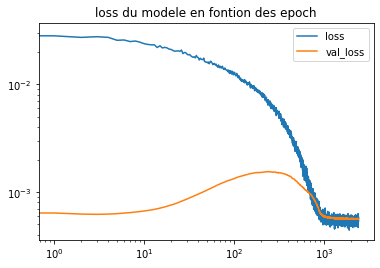

In [ ]:
plt.loglog(history.history['loss'],label='loss')
plt.loglog(history.history['val_loss'],label='val_loss')
plt.title('loss du modele en fontion des epoch')
plt.legend()
plt.show()

In [ ]:
Xtest_red,Xtrain_red = encoder(Xtest),encoder(Xtrain)

In [ ]:
Xtest_red,Xtrain_red = np.array(Xtest_red),np.array(Xtrain_red)
Ytest,Ytrain = (Ytest[:,0]==1)*1+(Ytest[:,1]==1)*2+(Ytest[:,2]==1)*3, (Ytrain[:,0]==1)*1+(Ytrain[:,1]==1)*2+(Ytrain[:,2]==1)*3

In [ ]:
import pickle

with open("vocab_reduc_encoder.txt", "wb") as f: 
  pickle.dump(list(V),f)

encoder.save(filepath = 'reduc_encoder.h5')

###le test

Dans ce test là nous remplacons le classifieur naive Bayes par le naive Bayes gaussien qui est adapté au valeur de sortie de l'encodeur. Nos features ne sont plus booleene, ainsi ont fait l'hypothese quelle suivent une gaussienne.



In [ ]:
CL = [GaussianNB(),
      DecisionTreeClassifier(max_depth=4),
      DecisionTreeClassifier(max_depth=8),
      SVC(),
      MLPClassifier(hidden_layer_sizes=(10),max_iter=5000),
      MLPClassifier(hidden_layer_sizes=(10,10),max_iter=5000),
      MLPClassifier(hidden_layer_sizes=(10,10,10,10,10),max_iter=5000), ]

NCL = ['GaussianNB',
       'DecisionTreeClassifier profondeur 4',
       'DecisionTreeClassifier profondeur 8',
       'SVC kernel rbf',
       'MLPClassifier 1 couche cachée',
       'MLPClassifier 2 couches cachées',
       'MLPClassifier 5 couches cachées',]

R = []

for i in range(len(NCL)):

    clf = CL[i]
    name = NCL[i]
    
    clf_sentiment = clf.fit(Xtrain_red,Ytrain)
    
    y_pred = clf_sentiment.predict(Xtest_red)

    d = metrics.classification_report(Ytest,y_pred,output_dict=True )

    r = []

    r.append(name)

    r.append(d['1']['f1-score'] )
    r.append(d['1']['precision'] )
    r.append(d['1']['recall'] )
  
    r.append(d['2']['f1-score'] )
    r.append(d['2']['precision'] )
    r.append(d['2']['recall'] )

    r.append(d['3']['f1-score'] )
    r.append(d['3']['precision'] )
    r.append(d['3']['recall'] )

    R.append(r)


In [ ]:
R = pd.DataFrame(R)
R.rename(columns= {0: 'clf name', 1: 'pos f1-score', 2:'pos precision',3:'pos recall',
                                    4: 'neg f1-score', 5:'neg precision',6:'neg recall',
                                    7: 'neu f1-score', 8:'neu precision',9:'neu recall'}, inplace = True)
R

,clf name,pos f1-score,pos precision,pos recall,neg f1-score,neg precision,neg recall,neu f1-score,neu precision,neu recall
0,GaussianNB,0.105452,0.251429,0.066717,0.539972,0.391658,0.869074,0.434486,0.636234,0.329882
1,DecisionTreeClassifier profondeur 4,0.152948,0.332487,0.099318,0.499322,0.454097,0.554552,0.597301,0.502269,0.736686
2,DecisionTreeClassifier profondeur 8,0.188181,0.386792,0.124337,0.496134,0.448360,0.555305,0.592322,0.503627,0.718935
3,SVC kernel rbf,0.072752,0.384058,0.040182,0.540178,0.396479,0.847254,0.525695,0.610568,0.461538
4,MLPClassifier 1 couche cachée,0.159903,0.397590,0.100076,0.528668,0.433880,0.676448,0.592266,0.546992,0.645710
5,MLPClassifier 2 couches cachées,0.236402,0.381113,0.171342,0.530016,0.451750,0.641084,0.576401,0.544379,0.612426
6,MLPClassifier 5 couches cachées,0.043259,0.441176,0.022745,0.516268,0.435977,0.632807,0.604471,0.506241,0.750000


#reduction avec reseau de neurone pré-entrainé

Ici nous allons de la même manière que precedemment entrainer un reseau qui posede 2 sous reseau mais celui ci est entrainé à predire les classe positif negatif et neutre.

On choisit la taille de notre reseau de telle manière qu'on reduise notre diemnsion en recuperant la sortie de l'avant dernier couche

In [ ]:
Xtest,Xtrain,Ytest,Ytrain,V = to_numpy(dataset)

### la reduction

In [ ]:
n=150

W0 = Input(shape=( nb_words ))
x = Dense(1500,activation='relu')(W0)
x = Dense(500,activation='relu')(x)
x = Dense(n,activation='relu')(x)
x = Dense(n,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(n,activation='relu')(x)
x = Dense(n,activation='relu')(x)
part0 = Model(W0,x)

W1 = Input(shape=( n ))
x = Dense(3,activation='softmax')(W1)
part1 = Model(W1,x)

classif = Model(inputs=part0.input, outputs=part1(part0.output))

classif.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15240)]           0         
_________________________________________________________________
dense_11 (Dense)             (None, 1500)              22861500  
_________________________________________________________________
dense_12 (Dense)             (None, 500)               750500    
_________________________________________________________________
dense_13 (Dense)             (None, 150)               75150     
_________________________________________________________________
dense_14 (Dense)             (None, 150)               22650     
_________________________________________________________________
batch_normalization_2 (Batch (None, 150)               600       
_________________________________________________________________
dense_15 (Dense)             (None, 150)             

In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=0.00001)

classif.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy','Recall'])

history = classif.fit(x = Xtrain,
                      y = Ytrain,
                      epochs=800,steps_per_epoch=1,batch_size=100,
                      verbose=0,
                      validation_data=(Xtest,Ytest))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in reciprocal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in reciprocal


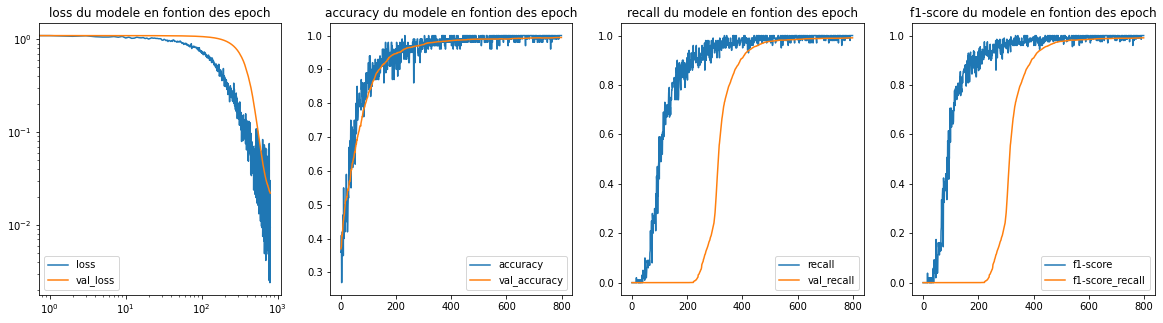

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(141)
plt.loglog(history.history['loss'], label = 'loss' )
plt.loglog(history.history['val_loss'] , label = 'val_loss')
plt.title('loss du modele en fontion des epoch')
plt.legend()

plt.subplot(142)
plt.plot(history.history['accuracy'] , label = 'accuracy')
plt.plot(history.history['val_accuracy'] , label = 'val_accuracy')
plt.legend()
plt.title('accuracy du modele en fontion des epoch')

plt.subplot(143)
plt.plot(history.history['recall'], label = 'recall' )
plt.plot(history.history['val_recall'] , label = 'val_recall')
plt.legend()
plt.title('recall du modele en fontion des epoch')

plt.subplot(144)
f = 2/( np.array(history.history['recall'])**-1 + np.array(history.history['accuracy'])**-1)
plt.plot(f, label = 'f1-score' )
f = 2/(np.array(history.history['val_recall'])**(-1) + np.array(history.history['val_accuracy'])**(-1))
plt.plot(history.history['val_recall'] , label = 'f1-score_recall')
plt.legend()
plt.title('f1-score du modele en fontion des epoch')

plt.show()

In [ ]:
Xtrain_red = part0(Xtrain)
Xtest_red = part0(Xtest)

In [ ]:
Xtest_red,Xtrain_red = np.array(Xtest_red),np.array(Xtrain_red)
Ytest,Ytrain = (Ytest[:,0]==1)*1 + (Ytest[:,1]==1)*2 + (Ytest[:,2]==1)*3, (Ytrain[:,0]==1)*1+(Ytrain[:,1]==1)*2+(Ytrain[:,2]==1)*3

In [ ]:
import pickle

with open("vocab_reduc_part0.txt", "wb") as f: 
  pickle.dump(list(V),f)

In [ ]:
part0.save(filepath='reduc_part0.h5')

###le test

In [ ]:
CL = [GaussianNB(),
      DecisionTreeClassifier(max_depth=4),
      DecisionTreeClassifier(max_depth=8),
      SVC(),
      MLPClassifier(hidden_layer_sizes=(10),max_iter=5000),
      MLPClassifier(hidden_layer_sizes=(10,10),max_iter=5000),
      MLPClassifier(hidden_layer_sizes=(10,10,10,10,10),max_iter=5000), ]

NCL = ['GaussianNB',
       'DecisionTreeClassifier profondeur 4',
       'DecisionTreeClassifier profondeur 8',
       'SVC kernel rbf',
       'MLPClassifier 1 couche cachée',
       'MLPClassifier 2 couches cachées',
       'MLPClassifier 5 couches cachées',]

R = []

for i in range(len(NCL)):

    clf = CL[i]
    name = NCL[i]
    
    clf_sentiment = clf.fit(Xtrain_red,Ytrain)
    
    y_pred = clf_sentiment.predict(Xtest_red)

    d = metrics.classification_report(Ytest,y_pred,output_dict=True )

    r = []

    r.append(name)

    r.append(d['1']['f1-score'] )
    r.append(d['1']['precision'] )
    r.append(d['1']['recall'] )
  
    r.append(d['2']['f1-score'] )
    r.append(d['2']['precision'] )
    r.append(d['2']['recall'] )

    r.append(d['3']['f1-score'] )
    r.append(d['3']['precision'] )
    r.append(d['3']['recall'] )

    R.append(r)


In [ ]:
R = pd.DataFrame(R)
R.rename(columns= {0: 'clf name', 1: 'pos f1-score', 2:'pos precision',3:'pos recall',
                                    4: 'neg f1-score', 5:'neg precision',6:'neg recall',
                                    7: 'neu f1-score', 8:'neu precision',9:'neu recall'}, inplace = True)
R

,clf name,pos f1-score,pos precision,pos recall,neg f1-score,neg precision,neg recall,neu f1-score,neu precision,neu recall
0,GaussianNB,0.992072,0.987970,0.996209,0.991357,0.990240,0.992476,0.985874,0.991031,0.980769
1,DecisionTreeClassifier profondeur 4,0.990555,0.987199,0.993935,0.989846,0.989474,0.990218,0.985152,0.988823,0.981509
2,DecisionTreeClassifier profondeur 8,0.991692,0.987961,0.995451,0.988705,0.989450,0.987961,0.985905,0.988839,0.982988
3,SVC kernel rbf,0.995825,0.996960,0.994693,0.993213,0.995465,0.990971,0.990048,0.986774,0.993343
4,MLPClassifier 1 couche cachée,0.995832,0.995455,0.996209,0.993592,0.995468,0.991723,0.991137,0.989676,0.992604
5,MLPClassifier 2 couches cachées,0.995455,0.994701,0.996209,0.991729,0.990984,0.992476,0.989630,0.991098,0.988166
6,MLPClassifier 5 couches cachées,0.995835,0.994705,0.996967,0.990598,0.990226,0.990971,0.989630,0.991098,0.988166


Récapitulons:

* On obtient des resultat correct en ne prennant que les 150 mots les plus important dans la classification Naive Bayes. Mais, comme attendu on n'égale pas les resultats de notre premier classifieur de bayes naif avec tout les mots (cf.Analyse_de_sentiment)

* Ensuite on remarque qu'avec l'autoencodeur les resultat sont très mauvais.Une explication possible est que 150 est une dimension trop petite pour reduire convenablement, trop d'information serait perdue.

* Pour finir, celui qui paraissait le plus adapté a notre probleme, utiliser l'avant dernière couche d'un reseau pré-entrainé à classer les tweets est le plus efficace. Cette reduction de dimension permet des resultats meillieurs qu'avec le premier classifieur (cf.Analyse_de_sentiment).

Maintenant que tous nous avons des outils d'analyse récuperons des donnée twitter, voir le notebook recuperation_tweet.